### SIDM with pyHalo

This notebook demonstrates how to generate realizations of self-interacting dark matter, in which a fraction of halos core collapse. 

In [12]:
from pyHalo.realization_extensions import RealizationExtensions
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
from pyHalo.PresetModels.cdm import CDM
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from lenstronomy.LensModel.lens_model import LensModel

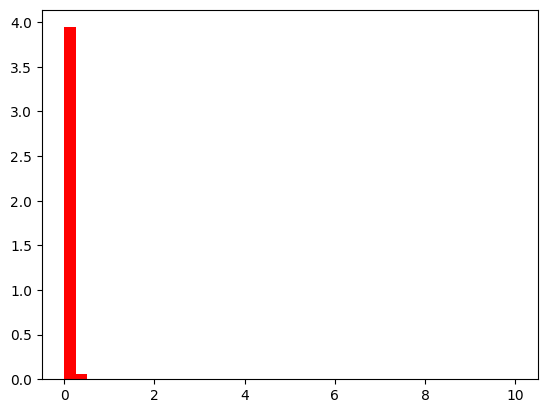

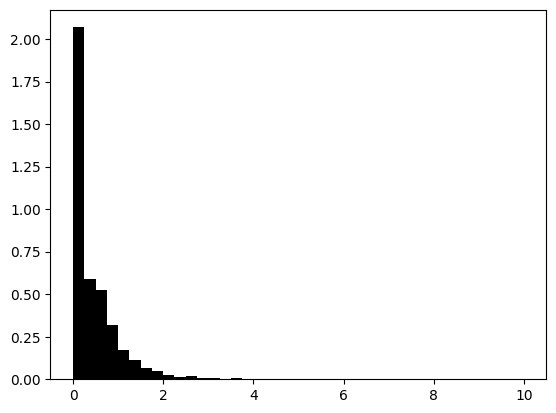

(array([1.58186398e+00, 2.92911119e-01, 1.75602735e-01, 1.92155452e-01,
        1.90716085e-01, 1.97193235e-01, 1.74883051e-01, 1.72724001e-01,
        1.49694135e-01, 1.36739834e-01, 1.18028068e-01, 8.42029507e-02,
        7.84454840e-02, 5.54156171e-02, 5.18172004e-02, 5.03778338e-02,
        5.10975171e-02, 3.38251169e-02, 2.23101835e-02, 2.30298669e-02,
        1.79920835e-02, 2.15905002e-02, 1.58330335e-02, 1.51133501e-02,
        2.08708168e-02, 5.75746671e-03, 9.35588341e-03, 5.75746671e-03,
        7.19683339e-03, 7.19683339e-03, 2.87873336e-03, 5.03778338e-03,
        3.59841670e-03, 7.91651673e-03, 3.59841670e-03, 5.75746671e-03,
        7.19683339e-04, 4.31810004e-03, 6.47715005e-03, 0.00000000e+00]),
 array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,
         2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,
         4.5 ,  4.75,  5.  ,  5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,
         6.75,  7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  

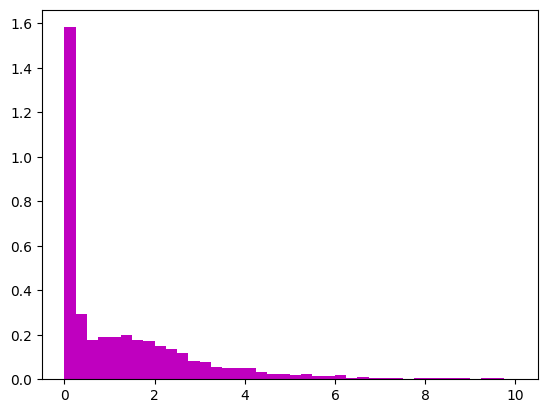

In [14]:
zlens, zsource = 0.5, 2.0
mass_ranges = [[6.0, 7.5], [7.5, 8.5], [8.5, 10.0]]

cdm_realization = CDM(zlens, zsource)
ext = RealizationExtensions(cdm_realization)

log10_subhalo_time_scaling = 0.0
sigma_eff = [0, 0, 0.0]
cdm_realization0 = ext.toSIDM_from_cross_section(mass_ranges, sigma_eff, log10_subhalo_time_scaling)

sigma_eff = [1.5,1.5,1.5]
sidm_realization1 = ext.toSIDM_from_cross_section(mass_ranges, sigma_eff, log10_subhalo_time_scaling)

sigma_eff = [2.5,2.5,2.5]
sidm_realization2 = ext.toSIDM_from_cross_section(mass_ranges, sigma_eff, log10_subhalo_time_scaling)

sigma_eff = [3.,3.,3.]
sidm_realization3 = ext.toSIDM_from_cross_section(mass_ranges, sigma_eff, log10_subhalo_time_scaling)

t = []
for halo in sidm_realization1.halos:
    t.append(halo.t_over_tc)
plt.hist(t, color='r',density=True, bins=40,range=(0, 10))
plt.show()
t = []
for halo in sidm_realization2.halos:
    t.append(halo.t_over_tc)
plt.hist(t, color='k',density=True, bins=40,range=(0, 10))
plt.show()
t = []
for halo in sidm_realization3.halos:
    t.append(halo.t_over_tc)
plt.hist(t, color='m',density=True, bins=40,range=(0, 10))

### Now we can compute the effective multiplane convergence with SIDM halos

In [15]:
npix = 350 
grid_resolution_critcurves = 0.04
grid_size = 1.5
_x = _y = np.linspace(-grid_size, grid_size, npix)
xx, yy = np.meshgrid(_x, _y)
shape0 = xx.shape

# power law plus shear macromodel
kwargs_macromodel = [{'theta_E': 1., 'center_x': 0., 'center_y': 0., 'e1': 0.2, 'e2': -0.1, 'gamma': 2.},
                    {'gamma1': -0.03, 'gamma2': 0.02}]
lens_model_list_macro = ['EPL', 'SHEAR']
lens_model_macro = LensModel(lens_model_list_macro)

residual_kappa_map_list = []
ra_crit_list_list = []
dec_crit_list_list = []

for sidm_realization in [cdm_realization0, sidm_realization1, sidm_realization2, sidm_realization3]:
    print(sidm_realization)
    
    lens_model_list, lens_redshift_array, kwargs_halos, _ = sidm_realization.lensing_quantities()

    astropy_instance = sidm_realization.astropy_instance

    lens_model_list_full = lens_model_list_macro + lens_model_list
    lens_redshift_list_full = [zlens, zlens] + list(lens_redshift_array)
    kwargs_lens_full = kwargs_macromodel + kwargs_halos

    lens_model_full = LensModel(lens_model_list_full, zlens, zsource, 
                            lens_redshift_list_full, cosmo=astropy_instance, multi_plane=True, 
                            numerical_alpha_class=None)


    kappa_full = lens_model_full.kappa(xx.ravel(), yy.ravel(), kwargs_lens_full).reshape(shape0)
    kappa_macro = lens_model_macro.kappa(xx.ravel(), yy.ravel(), kwargs_macromodel).reshape(shape0)
    residual_kappa_map_list.append(kappa_full - kappa_macro)

    lens_model_extension = LensModelExtensions(lens_model_full)
    
    ra_crit_list, dec_crit_list, _, _ = lens_model_extension.critical_curve_caustics(kwargs_lens_full, 
                                                                compute_window=2*grid_size, 
                                                                grid_scale=grid_resolution_critcurves)
    ra_crit_list_list.append(ra_crit_list)
    dec_crit_list_list.append(dec_crit_list)


### Make the figure

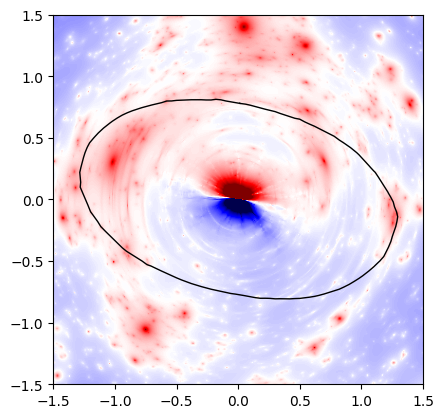

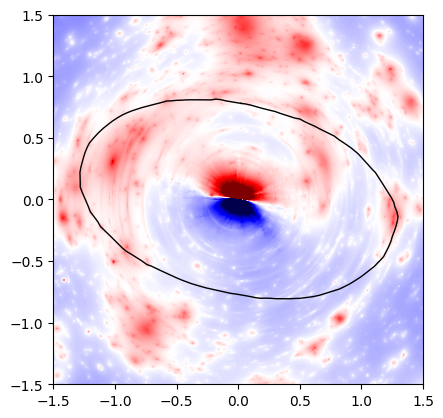

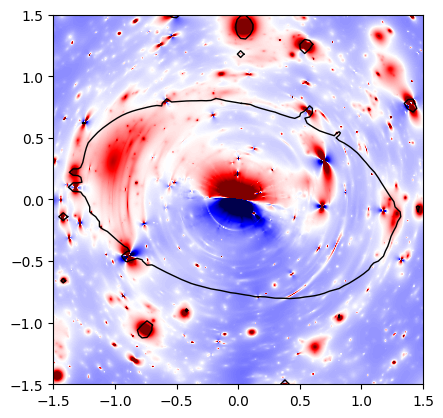

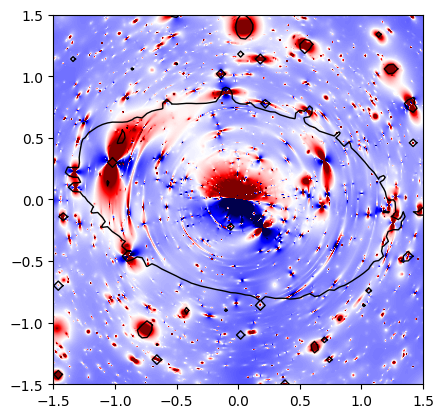

In [16]:
for (kap, rac, dec) in zip(residual_kappa_map_list, ra_crit_list_list, dec_crit_list_list):
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.imshow(kap- np.mean(kap), vmin=-0.1, vmax=0.1, cmap='seismic',
             extent=[-grid_size, grid_size, -grid_size, grid_size], origin='lower')
    for i in range(0, len(rac)):
        ax.plot(rac[i], dec[i], color='k', lw=1)
    plt.show()

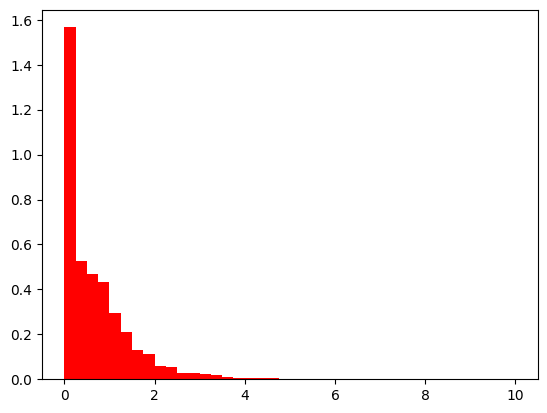

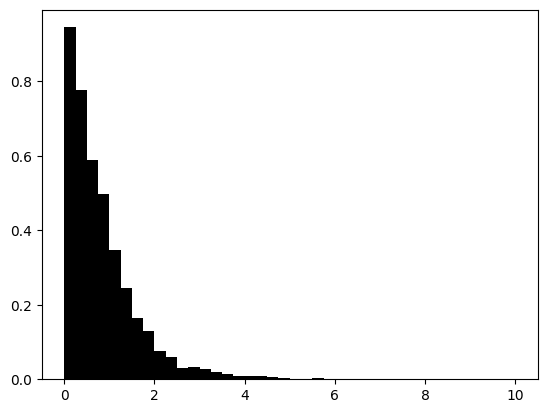

(array([1.38073870e-01, 6.66206420e-01, 7.29720400e-01, 6.19261305e-01,
        4.57024508e-01, 3.23092855e-01, 2.21608561e-01, 1.80186400e-01,
        1.13910942e-01, 1.08387988e-01, 7.93924750e-02, 5.45391785e-02,
        5.59199172e-02, 4.28028996e-02, 3.86606835e-02, 2.27821885e-02,
        2.34725578e-02, 2.55436659e-02, 1.72592337e-02, 1.31170176e-02,
        7.59406282e-03, 8.28443217e-03, 5.52295478e-03, 8.97480152e-03,
        7.59406282e-03, 7.59406282e-03, 4.14221609e-03, 1.38073870e-03,
        4.83258543e-03, 2.76147739e-03, 1.38073870e-03, 6.90369348e-04,
        1.38073870e-03, 2.07110804e-03, 1.38073870e-03, 0.00000000e+00,
        2.07110804e-03, 6.90369348e-04, 6.90369348e-04, 0.00000000e+00]),
 array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,
         2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,
         4.5 ,  4.75,  5.  ,  5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,
         6.75,  7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  

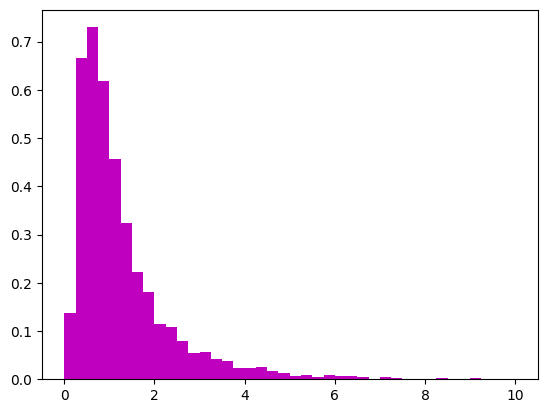

In [22]:
zlens, zsource = 0.5, 2.0
mass_ranges = [[6.0, 7.5], [7.5, 8.5], [8.5, 10.0]]

cdm_realization = CDM(zlens, zsource)
ext = RealizationExtensions(cdm_realization)

log10_subhalo_time_scaling = -0.5
sigma_eff = [2.7,2.3,1.5]
cdm_realization0 = ext.toSIDM_from_cross_section(mass_ranges, sigma_eff, log10_subhalo_time_scaling)

log10_subhalo_time_scaling = 0.4
sidm_realization1 = ext.toSIDM_from_cross_section(mass_ranges, sigma_eff, log10_subhalo_time_scaling)

log10_subhalo_time_scaling = 0.8
sidm_realization2 = ext.toSIDM_from_cross_section(mass_ranges, sigma_eff, log10_subhalo_time_scaling)

log10_subhalo_time_scaling = 1.3
sidm_realization3 = ext.toSIDM_from_cross_section(mass_ranges, sigma_eff, log10_subhalo_time_scaling)

t = []
for halo in sidm_realization1.halos:
    t.append(halo.t_over_tc)
plt.hist(t, color='r',density=True, bins=40,range=(0, 10))
plt.show()
t = []
for halo in sidm_realization2.halos:
    t.append(halo.t_over_tc)
plt.hist(t, color='k',density=True, bins=40,range=(0, 10))
plt.show()
t = []
for halo in sidm_realization3.halos:
    t.append(halo.t_over_tc)
plt.hist(t, color='m',density=True, bins=40,range=(0, 10))

In [23]:
npix = 250 
grid_resolution_critcurves = 0.04
grid_size = 1.5
_x = _y = np.linspace(-grid_size, grid_size, npix)
xx, yy = np.meshgrid(_x, _y)
shape0 = xx.shape

# power law plus shear macromodel
kwargs_macromodel = [{'theta_E': 1., 'center_x': 0., 'center_y': 0., 'e1': 0.2, 'e2': -0.1, 'gamma': 2.},
                    {'gamma1': -0.03, 'gamma2': 0.02}]
lens_model_list_macro = ['EPL', 'SHEAR']
lens_model_macro = LensModel(lens_model_list_macro)

residual_kappa_map_list = []
ra_crit_list_list = []
dec_crit_list_list = []

for sidm_realization in [cdm_realization0, sidm_realization1, sidm_realization2, sidm_realization3]:
    print(sidm_realization)
    
    lens_model_list, lens_redshift_array, kwargs_halos, _ = sidm_realization.lensing_quantities()

    astropy_instance = sidm_realization.astropy_instance

    lens_model_list_full = lens_model_list_macro + lens_model_list
    lens_redshift_list_full = [zlens, zlens] + list(lens_redshift_array)
    kwargs_lens_full = kwargs_macromodel + kwargs_halos

    lens_model_full = LensModel(lens_model_list_full, zlens, zsource, 
                            lens_redshift_list_full, cosmo=astropy_instance, multi_plane=True, 
                            numerical_alpha_class=None)


    kappa_full = lens_model_full.kappa(xx.ravel(), yy.ravel(), kwargs_lens_full).reshape(shape0)
    kappa_macro = lens_model_macro.kappa(xx.ravel(), yy.ravel(), kwargs_macromodel).reshape(shape0)
    residual_kappa_map_list.append(kappa_full - kappa_macro)

    lens_model_extension = LensModelExtensions(lens_model_full)
    
    ra_crit_list, dec_crit_list, _, _ = lens_model_extension.critical_curve_caustics(kwargs_lens_full, 
                                                                compute_window=2*grid_size, 
                                                                grid_scale=grid_resolution_critcurves)
    ra_crit_list_list.append(ra_crit_list)
    dec_crit_list_list.append(dec_crit_list)


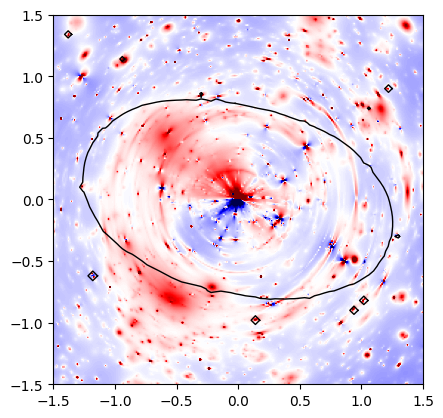

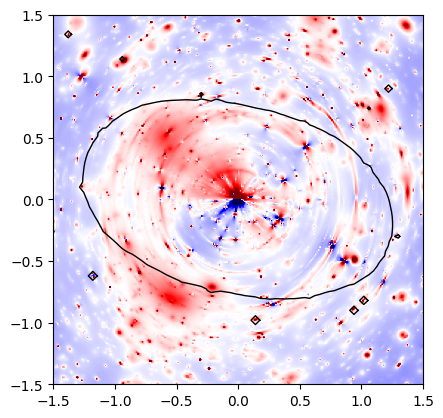

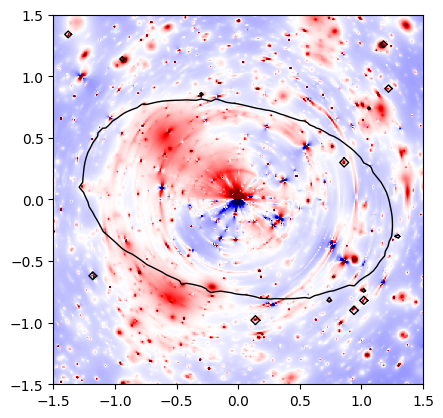

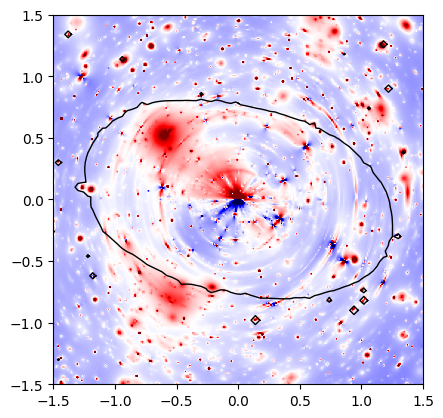

In [24]:
for (kap, rac, dec) in zip(residual_kappa_map_list, ra_crit_list_list, dec_crit_list_list):
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.imshow(kap-np.mean(kap), vmin=-0.1, vmax=0.1, cmap='seismic',
             extent=[-grid_size, grid_size, -grid_size, grid_size], origin='lower')
    for i in range(0, len(rac)):
        ax.plot(rac[i], dec[i], color='k', lw=1)
    plt.show()